# Topic Modeling: Depression

### The first step is importing the packages that we will be using for identifying topic models.

In [1]:
# Import required packages

# DATA PREPROCESSING
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Phrases

# MODELING
import sklearn
import re
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

# VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
import pickle 

# OTHER
import numpy as np
import pandas as pd
import logging
import json
import warnings
import random

warnings.filterwarnings('ignore')  

### In the second step, we read the dataset, and take a glance at what it looks like.

In [2]:
data = pd.read_csv('depression.csv')

In [3]:
data.head()

,user_ID,followers_count,user_location,user_description,date,text,hashtags
0,1.390000e+18,53,"Barcelona, Spain","For 34 years, Psych Congress has served as a u...",10/27/2021 11:45,Extended abstract submission deadline is TODAY...,NaN
1,2.350451e+09,30626,"Sacramento, California",Believer in creating a healthy game plan to fe...,10/27/2021 11:39,"🌟This Fall and if you can, intentionally spend...",['anxiety']
2,3.345540e+09,829,"Pittsburgh, PA","Founder Motivation Champs, Publisher 📚, Screen...",10/27/2021 11:38,Proud to welcome Stephanie Kunkel to the Motiv...,NaN
3,1.174093e+07,3089,"Toronto, Canada",Self healing journey from ✝️ trauma to spiritu...,10/27/2021 11:35,How much energy do you put into keeping up app...,['travelblogger']
4,4.008473e+09,417,"London, England",rTMS treatment across the UK and Ireland.\r\r\...,10/27/2021 11:35,Did you know that we treat seasonal affective ...,"['seasonalaffectivedisorder', 'SAD']"


### Then, we extract our column of interest, which is the tweet.

In [4]:
tweets = data['text']

### Once we have the tweets, we pre-process the data to make it ready for analysis.

Initially, we convert everything to lowercase, and then we remove users, links, punctuation, double spaces, numbers, short words, emojis and stopwords.

Then, we tokenize each word, splitting the sentences in separate words.

Lasly, we convert each word into their lemmas (the form of a word under which it is registered in a dictionary).

In [5]:
# list of commonly repeated words that do not add meanings
my_stopwords = nltk.corpus.stopwords.words('english')
repeated_words = ['ever', 'start', 'pre', '&amp', 
                  'amp', 'may', 'and', 'when',
                  'what','who', 'why','how', 
                  'this', 'your', 'mine', 'their',
                  'her', 'his', 'that', 'mental']

for i in repeated_words:
    my_stopwords.append(i)
    
tweets = tweets.apply(lambda x: ' '.join([word for word in x.split() if word not in (my_stopwords)]))
tweets = array(tweets)
    
# list of common punctuation    
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`’{|}~•@'

# list of the majority of emojis
emoj = re.compile("["  
    u"\U0001F600-\U0001F64F" 
    u"\U0001F300-\U0001F5FF" 
    u"\U0001F680-\U0001F6FF"  
    u"\U0001F1E0-\U0001F1FF"  
    u"\U00002500-\U00002BEF"  
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642" 
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  
    u"\u3030"
                  "]+", re.UNICODE) 

In [6]:
def preprocessor(tweets):
    """
    Removes unnecessary information from tweets,
    and lemmatizes the tweets.

    Input(s):
    ------------------------------
    tweets(array): all original tweets
    
    Output(s):
    ------------------------------
    tweets(array): cleaned up and lemmatized tweets
    """
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(tweets)):       
        tweets[idx] = re.sub(r'http\S+', '', tweets[idx]) # http links
        tweets[idx] = re.sub(r'bit.ly/\S+', '', tweets[idx]) # bitly links
        tweets[idx] = tweets[idx].strip('[link]') # other links(i.e. gifs)
        tweets[idx] = tweets[idx].lower()  # turn to lowercase
        tweets[idx] = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweets[idx]) # retweets
        tweets[idx] = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweets[idx]) # tweeted at
        tweets[idx] = re.sub ('#', '', tweets[idx]) # hashtags
        tweets[idx] = re.sub(emoj, '', tweets[idx]) # emojis
        tweets[idx] = re.sub('['+my_punctuation + ']+', ' ', tweets[idx]) # remove punctuation
        tweets[idx] = re.sub('\s+', ' ', tweets[idx]) # remove double spacing
        tweets[idx] = tokenizer.tokenize(tweets[idx])   # split into words


    # numbers (but not words with number)
    tweets = [[token for token in tweet if not token.isdigit()] for tweet in tweets]
    
    # words that are only one character
    tweets = [[token for token in tweet if len(token) > 3] for tweet in tweets]
    
    # lemmatize all words in documents
    lemmatizer = WordNetLemmatizer()
    tweets = [[lemmatizer.lemmatize(token) for token in tweet] for tweet in tweets]
 
    return tweets

In [7]:
tweets = preprocessor(tweets)

### We also create bi- and trigrams, and remove words that appear rarely. This is words that occurr frequently together, for example "more_than, less_than".

In [8]:
# add bigrams and trigrams to docs

# only add bi/trigrams that appear > 10 times
bigram = Phrases(tweets, min_count=10)
trigram = Phrases(bigram[tweets])

for idx in range(len(tweets)):
    for token in bigram[tweets[idx]]:
        if '_' in token:
            tweets[idx].append(token)
    for token in trigram[tweets[idx]]:
        if '_' in token:
            tweets[idx].append(token)

dictionary = Dictionary(tweets)
dictionary.filter_extremes(no_below=10, no_above=0.2)

corpus = [dictionary.doc2bow(t) for t in tweets]

### After being ready for analysis, we analyze this data with Latent Dirichlet Allocation model by assigning a random number of topics.

In [9]:
num_topics = 5 # number of topics

temp = dictionary[0] 
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=len(data)/5, \
                       alpha='auto', eta='auto', \
                       iterations=20, num_topics=num_topics, \
                       passes=20, eval_every=1)

# show keywords
print(lda_model.print_topics())

[(0, '0.099*"really_help" + 0.099*"research_find" + 0.066*"acupuncture" + 0.066*"performance_always" + 0.066*"evidence_back" + 0.066*"beneficial_good" + 0.034*"always" + 0.034*"find" + 0.034*"back" + 0.033*"really"'), (1, '0.098*"million_case" + 0.098*"disorder_pandemic" + 0.066*"study_published" + 0.065*"document_world" + 0.065*"lancet_october" + 0.065*"wide_increase" + 0.034*"disorder" + 0.034*"study" + 0.034*"world" + 0.033*"pandemic"'), (2, '0.020*"therapy" + 0.019*"online" + 0.017*"online_mindfulness" + 0.012*"mindfulness" + 0.011*"help" + 0.010*"like" + 0.008*"depressiontreatment_depressionrecovery" + 0.008*"life" + 0.008*"people" + 0.008*"feel"'), (3, '0.141*"live_podcast" + 0.094*"quote_radio" + 0.050*"live" + 0.050*"quote" + 0.049*"podcast" + 0.047*"lgbtq" + 0.047*"radio" + 0.047*"iheart" + 0.047*"irving_iheart" + 0.047*"lgbtq_kyrie"'), (4, '0.031*"health" + 0.017*"mentalhealthawareness" + 0.016*"mental_health" + 0.014*"help" + 0.013*"mentalhealthmatters" + 0.011*"stress" + 0.

### We check the accuracy of our model with coherence scores (through CV, and UMass).

High values of c_v and low values of UMass indicate higher accuracy.

In [10]:
# coherence score (c_v)
coherence_model_cv = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_cv.get_coherence()
print('\nCoherence Score: ', coherence_score)


Coherence Score:  0.6934296832827711


In [11]:
coherence_model_cv = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='u_mass')
coherence_score = coherence_model_cv.get_coherence()
print('\nCoherence Score: ', coherence_score)


Coherence Score:  -4.41353716313626


### To determine the ideal number of topics, we run a simulation with different number of topics and keep track of the coherence scores.

In [12]:
def simulate_coherence_values(dictionary, corpus, texts, limit=11):
    """
    Simulate c_v for multiple LDA models with different number of topics.

    Input:
    ----------
    dictionary (dict) : gensim dictionary
    corpus (list): gensim corpus
    texts (list): list of input texts
    limit (int): maximum number of topics

    Output:
    -------
     coherence_scores : coherence scores corresponding to the LDA model with respective number of topics
    """
    coherence_scores = []
    models = []
    for num_topics in range(2,limit):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherencemodel.get_coherence())
        models.append(model)

    return coherence_scores, models

In [13]:
coherence_values, models = simulate_coherence_values(dictionary=dictionary, corpus=corpus, texts=tweets)

In [14]:
coherence_values

[0.5525151283820398,
 0.9671766920776551,
 0.8333867779876124,
 0.7249608640926901,
 0.5998468702100527,
 0.6577556119687193,
 0.49246305351926356,
 0.5524409079190951,
 0.5276854788294896]

In [15]:
# pick the best model, with the highest coherence score
best_model = models[(coherence_values.index(max(coherence_values)))]

### We plot the results of the simulation and find out that the ideal number of topics is 4.

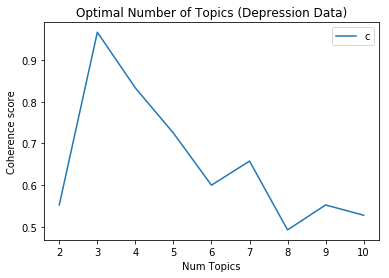

In [16]:
limit=11; start=2; 
x = range(start, limit)
plt.plot(x, coherence_values)
plt.title('Optimal Number of Topics (Depression Data)')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Once we have the weights and frequency of topic words, we are able to visualize the topics.

In [17]:
# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_viz = pyLDAvis.gensim.prepare(best_model, corpus, dictionary)
LDAvis_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.359384 -0.043705       1        1  38.997966
2      0.257722 -0.129119       2        1  34.098375
0      0.101663  0.172825       3        1  26.903659, topic_info=                                Term          Freq         Total Category  \
term                                                                        
1197                    million_case  10776.000000  10776.000000  Default   
1196               disorder_pandemic  10359.000000  10359.000000  Default   
839                      really_help   5728.000000   5728.000000  Default   
1210                   research_find   5586.000000   5586.000000  Default   
1229                   wide_increase   6519.000000   6519.000000  Default   
1227                  lancet_october   6519.000000   6519.000000  Default   
1225                  document_world   6519.000000   6519.000000  Default   
1195                 study_published   5336.000000   5336.000000  Default   
807                          million   3624.000000   3624.000000  Default   
640                         pandemic   3638.000000   3638.000000  Default   
1201                     acupuncture   3726.000000   3726.000000  Default   
1207                   evidence_back   3723.000000   3723.000000  Default   
1202                 beneficial_good   3723.000000   3723.000000  Default   
1209              performance_always   3723.000000   3723.000000  Default   
1071                       published   2464.000000   2464.000000  Default   
684                             wide   2494.000000   2494.000000  Default   
805                          october   2590.000000   2590.000000  Default   
1224                        document   3390.000000   3390.000000  Default   
1190                          lancet   2596.000000   2596.000000  Default   
11                              help   2982.000000   2982.000000  Default   
1226    document_world_wide_increase   3260.000000   3260.000000  Default   
1228  study_published_lancet_october   3260.000000   3260.000000  Default   
571                         research   2159.000000   2159.000000  Default   
78                              find   2144.000000   2144.000000  Default   
153                           really   2166.000000   2166.000000  Default   
308                             good   2164.000000   2164.000000  Default   
62                            always   2104.000000   2104.000000  Default   
75                              back   2103.000000   2103.000000  Default   
7                              world   2752.000000   2752.000000  Default   
262                             case   2708.000000   2708.000000  Default   
...                              ...           ...           ...      ...   
1190                          lancet   2104.203340   2596.565461   Topic3   
1195                 study_published   4220.042495   5336.514126   Topic3   
127                           health    330.714415    404.825399   Topic3   
7                              world   1952.313667   2752.827313   Topic3   
262                             case   1919.441926   2708.402631   Topic3   
289                            study   1941.076946   2823.859759   Topic3   
121               online_mindfulness    293.811314    383.553791   Topic3   
591                            major   1662.763858   2850.653957   Topic3   
132              mentalhealthmatters   1712.575543   3089.006830   Topic3   
404                             with     99.657689    117.690927   Topic3   
84                            stress    133.956718    172.068635   Topic3   
42                          disorder   1298.754714   3115.573649   Topic3   
120                      mindfulness    228.596398    342.889123   Topic3   
271                         increase   1241.404246   3045.677384   Topic3   
39                           therapy    300.981323    537.118397   T

### We interpret the topics based on the keywords.

In [26]:
print('1: Treatment/Tips')
print('2: Stats/Pandemic news')
print('3: Studies/Publications')

1: Treatment/Tips
2: Stats/Pandemic news
3: Studies/Publications


### Finally, we label the data and save it.

In [27]:
cat_name = ['Treatment/Tips', 'Stats/Pandemic News', 'Studies/Publications']

def add_labels(model=best_model, corpus=corpus, data=data):
    # get main topic in each document
    topics = []
    categories = []
    for i, row in enumerate(model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # dominant topic
                wp = model.show_topic(topic_num)
                topics.append(topic_num+1)
                categories.append(cat_name[topic_num])
            else:
                break
    data['category'] = categories
    data['class'] = topics
    return data.reset_index()

In [28]:
data_labelled = add_labels(model=best_model, corpus=corpus, data=data)

In [29]:
data_labelled.category.describe()

count              16733
unique                 3
top       Treatment/Tips
freq               10537
Name: category, dtype: object

In [30]:
data_labelled['class'].unique()

array([1, 2, 3], dtype=int64)

In [31]:
data.head()

,user_ID,followers_count,user_location,user_description,date,text,hashtags,category,class
0,1.390000e+18,53,"Barcelona, Spain","For 34 years, Psych Congress has served as a u...",10/27/2021 11:45,Extended abstract submission deadline is TODAY...,NaN,Treatment/Tips,1
1,2.350451e+09,30626,"Sacramento, California",Believer in creating a healthy game plan to fe...,10/27/2021 11:39,"🌟This Fall and if you can, intentionally spend...",['anxiety'],Treatment/Tips,1
2,3.345540e+09,829,"Pittsburgh, PA","Founder Motivation Champs, Publisher 📚, Screen...",10/27/2021 11:38,Proud to welcome Stephanie Kunkel to the Motiv...,NaN,Treatment/Tips,1
3,1.174093e+07,3089,"Toronto, Canada",Self healing journey from ✝️ trauma to spiritu...,10/27/2021 11:35,How much energy do you put into keeping up app...,['travelblogger'],Treatment/Tips,1
4,4.008473e+09,417,"London, England",rTMS treatment across the UK and Ireland.\r\r\...,10/27/2021 11:35,Did you know that we treat seasonal affective ...,"['seasonalaffectivedisorder', 'SAD']",Treatment/Tips,1


In [33]:
for i in range(3):
    random_tweet = random.randint(1,len(data))
    print('Tweet:', data.text[random_tweet])
    print('************************************************************')
    print('Category:', data.category[random_tweet])
    print('--------------------------------------------------------------------------------------------------------------------------------')




#2021EBE #Biology #depression
************************************************************
Category: Treatment/Tips
--------------------------------------------------------------------------------------------------------------------------------
Tweet: Skype Therapist for #anxiety and #depression https://t.co/5WjxvQCxf5 #onlinetherapy #onlinepsychotherapy #onlinecounseling
************************************************************
Category: Treatment/Tips
--------------------------------------------------------------------------------------------------------------------------------
Tweet: A new study published in the Lancet on 8 October 2021 documents a world-wide increase of more than 129 million cases of major #depression (53.2mn) and #anxiety (76.2mn) disorders during the #pandemic https://t.co/2ZrVYEY9sX #MentalHealthMatters https://t.co/x2MeI2XNIz
************************************************************
Category: Studies/Publications
---------------------------------------

In [34]:
data.to_csv('Depression with TM labels.csv')